In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
chip_sales = pd.read_csv('QVI_transaction_data.csv')

In [20]:
chip_sales.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND,PACK_SIZE,UNIT_PRICE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,17/10/2018,1,1000,1,5,Natural Chip Company SeaSalt,Natural Chip Co,175,3.00,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,14/05/2019,1,1307,348,66,CCs Nacho Cheese,CC's,175,2.10,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,20/05/2019,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,Smith's,170,1.45,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,17/08/2018,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion,Smith's,175,3.00,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,18/08/2018,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili,Kettle,150,4.60,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [21]:
# Convert DATE to datetime
chip_sales['DATE'] = pd.to_datetime(chip_sales['DATE'], dayfirst=True)

# Check the date range
print(f"Date range: {chip_sales['DATE'].min()} to {chip_sales['DATE'].max()}")
print(f"Number of unique dates: {chip_sales['DATE'].nunique()}")

Date range: 2018-07-01 00:00:00 to 2019-06-30 00:00:00
Number of unique dates: 364


In [22]:
# Group by date and count transactions
daily_transactions = chip_sales.groupby('DATE').size().reset_index(name='Transaction_Count')

print(f"Number of days with transactions: {len(daily_transactions)}")
daily_transactions.head(10)

Number of days with transactions: 364


,DATE,Transaction_Count
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
5,2018-07-06,711
6,2018-07-07,695
7,2018-07-08,653
8,2018-07-09,692
9,2018-07-10,650


In [23]:
# Create a complete date range
start_date = pd.to_datetime('2018-07-01')
end_date = pd.to_datetime('2019-06-30')

# Generate all dates in the range
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
full_date_df = pd.DataFrame({'DATE': all_dates})

print(f"Total days in period: {len(full_date_df)}")

Total days in period: 365


In [24]:
# Merge the full date range with actual transactions
merged_dates = full_date_df.merge(daily_transactions, on='DATE', how='left')

# Fill NaN with 0 (days with no transactions)
merged_dates['Transaction_Count'] = merged_dates['Transaction_Count'].fillna(0)

# Find the missing date(s)
missing_dates = merged_dates[merged_dates['Transaction_Count'] == 0]

print("\nMissing Date(s):")
print(missing_dates)


Missing Date(s):
          DATE  Transaction_Count
177 2018-12-25                0.0


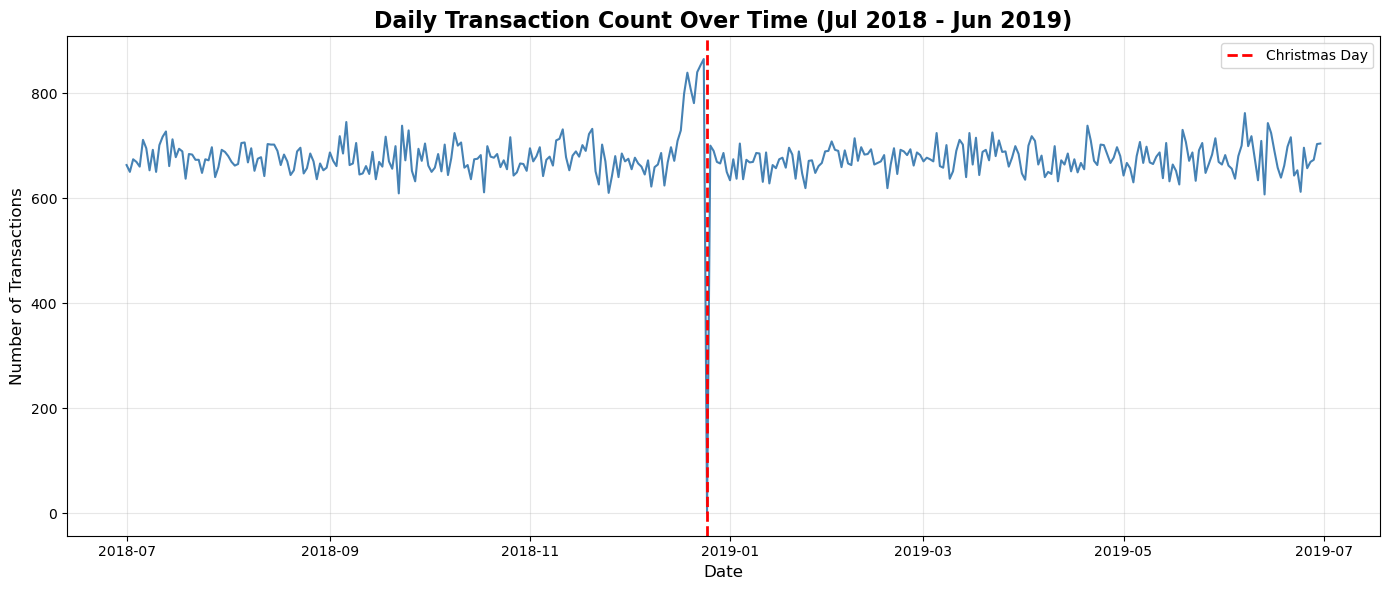


✓ Expected Result: Spike in December followed by drop to zero on Christmas Day (25 Dec 2018)


In [25]:
plt.figure(figsize=(14, 6))
plt.plot(merged_dates['DATE'], merged_dates['Transaction_Count'], linewidth=1.5, color='steelblue')
plt.axvline(pd.to_datetime('2018-12-25'), color='red', linestyle='--', linewidth=2, label='Christmas Day')

plt.title('Daily Transaction Count Over Time (Jul 2018 - Jun 2019)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Expected Result: Spike in December followed by drop to zero on Christmas Day (25 Dec 2018)")

In [26]:
# Check if required columns exist
required_cols = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'TOT_SALES', 'LYLTY_CARD_NBR', 'PROD_QTY']
missing_cols = [col for col in required_cols if col not in chip_sales.columns]

if missing_cols:
    print(f"  Missing columns: {missing_cols}")
    print(f"Available columns: {chip_sales.columns.tolist()}")
else:
    print(" All required columns present!")

# Display unique values in segmentation columns
print(f"\nUnique LIFESTAGE values ({chip_sales['LIFESTAGE'].nunique()}):")
print(chip_sales['LIFESTAGE'].unique())
print(f"\nUnique PREMIUM_CUSTOMER values ({chip_sales['PREMIUM_CUSTOMER'].nunique()}):")
print(chip_sales['PREMIUM_CUSTOMER'].unique())

 All required columns present!

Unique LIFESTAGE values (7):
['YOUNG SINGLES/COUPLES' 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES'
 'OLDER FAMILIES' 'OLDER SINGLES/COUPLES' 'RETIREES' 'YOUNG FAMILIES']

Unique PREMIUM_CUSTOMER values (3):
['Premium' 'Budget' 'Mainstream']


In [27]:
# Group by LIFESTAGE and PREMIUM_CUSTOMER and calculate all metrics
segment_metrics = chip_sales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'TOT_SALES': 'sum',           # Metric A: Total Sales
    'LYLTY_CARD_NBR': 'nunique',  # Metric B: Customer Count (unique customers)
    'PROD_QTY': 'sum'             # Used for Metrics C & D
}).reset_index()

# Rename columns for clarity
segment_metrics.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Total_Sales', 'Customer_Count', 'Total_Qty']

# Metric C: Average Units per Customer
segment_metrics['Avg_Units_per_Customer'] = segment_metrics['Total_Qty'] / segment_metrics['Customer_Count']

# Metric D: Average Price per Unit
segment_metrics['Avg_Price_per_Unit'] = segment_metrics['Total_Sales'] / segment_metrics['Total_Qty']

# Create a combined segment label for easier visualization
segment_metrics['Segment'] = segment_metrics['PREMIUM_CUSTOMER'] + ' - ' + segment_metrics['LIFESTAGE']

# Display the metrics
print("\n" + "="*70)
print("SEGMENT METRICS SUMMARY")
print("="*70)
print(segment_metrics.sort_values('Total_Sales', ascending=False).to_string())


SEGMENT METRICS SUMMARY
                 LIFESTAGE PREMIUM_CUSTOMER  Total_Sales  Customer_Count  Total_Qty  Avg_Units_per_Customer  Avg_Price_per_Unit                              Segment
6           OLDER FAMILIES           Budget    156863.75            4611      41853                9.076773            3.747969              Budget - OLDER FAMILIES
19   YOUNG SINGLES/COUPLES       Mainstream    147582.20            7917      36225                4.575597            4.074043   Mainstream - YOUNG SINGLES/COUPLES
13                RETIREES       Mainstream    145168.95            6358      37677                5.925920            3.852986                Mainstream - RETIREES
15          YOUNG FAMILIES           Budget    129717.95            3953      34482                8.722995            3.761903              Budget - YOUNG FAMILIES
9    OLDER SINGLES/COUPLES           Budget    127833.60            4849      32883                6.781398            3.887529       Budget - OLDER S

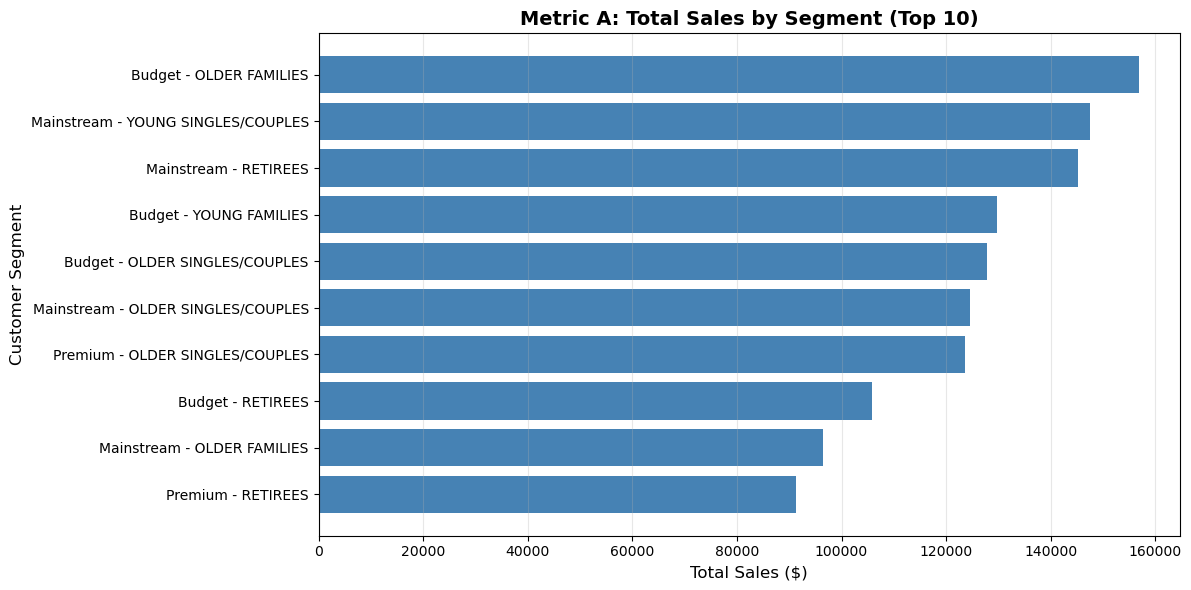


 Insight: Shows which segments bring in the most revenue.
Top segment: Budget - OLDER FAMILIES with $156,863.75


In [30]:
# Sort by Total Sales and get top 10
top_sales = segment_metrics.sort_values('Total_Sales', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_sales['Segment'], top_sales['Total_Sales'], color='steelblue')
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)
plt.title('Metric A: Total Sales by Segment (Top 10)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Insight: Shows which segments bring in the most revenue.")
print(f"Top segment: {top_sales.iloc[0]['Segment']} with ${top_sales.iloc[0]['Total_Sales']:,.2f}")

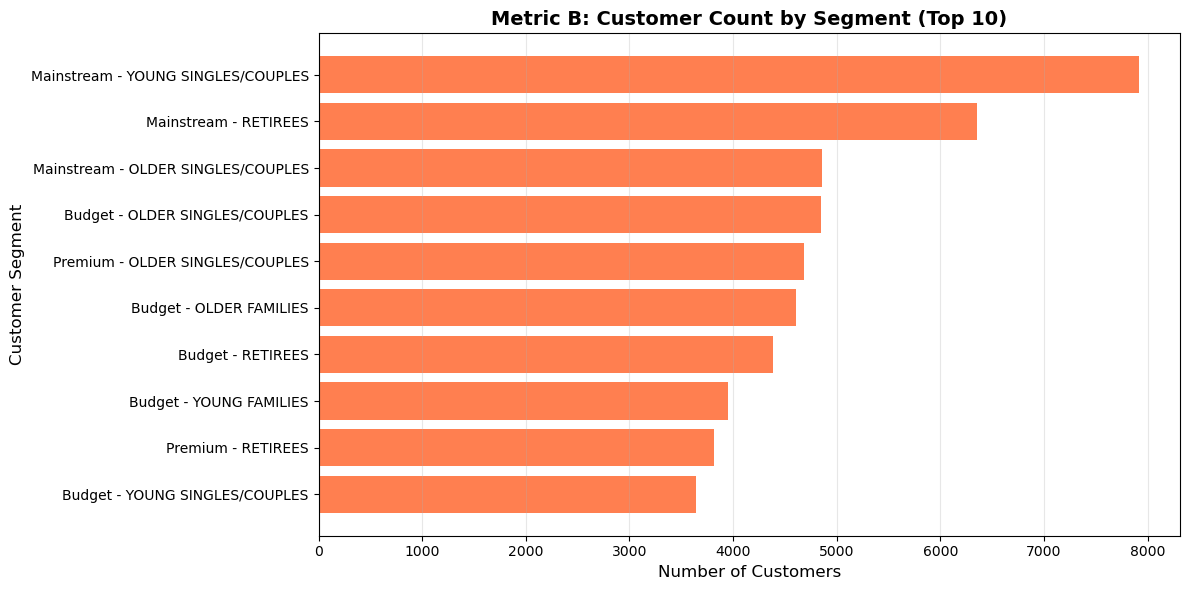


 Insight: Shows if high sales are driven by having more customers in that segment.
Largest segment: Mainstream - YOUNG SINGLES/COUPLES with 7,917 customers


In [31]:
# Sort by Customer Count and get top 10
top_customers = segment_metrics.sort_values('Customer_Count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_customers['Segment'], top_customers['Customer_Count'], color='coral')
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)
plt.title('Metric B: Customer Count by Segment (Top 10)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Insight: Shows if high sales are driven by having more customers in that segment.")
print(f"Largest segment: {top_customers.iloc[0]['Segment']} with {top_customers.iloc[0]['Customer_Count']:,} customers")

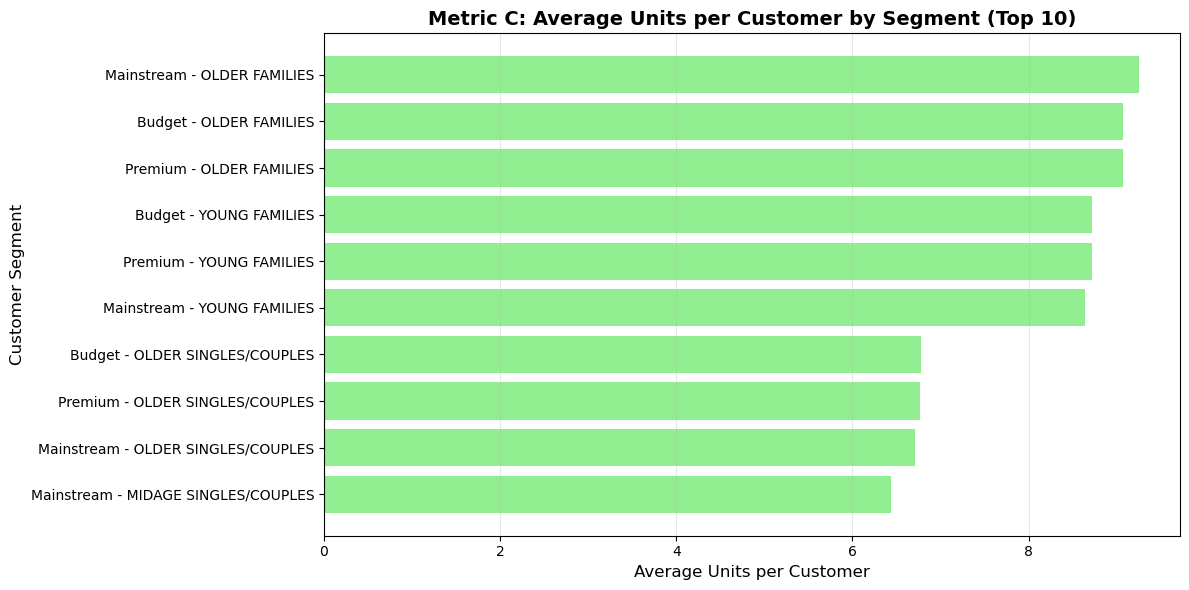


 Insight: Shows which segments buy the most chip bags per person annually.
Highest purchasers: Mainstream - OLDER FAMILIES with 9.3 units/customer


In [32]:
# Sort by Average Units per Customer and get top 10
top_units = segment_metrics.sort_values('Avg_Units_per_Customer', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_units['Segment'], top_units['Avg_Units_per_Customer'], color='lightgreen')
plt.xlabel('Average Units per Customer', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)
plt.title('Metric C: Average Units per Customer by Segment (Top 10)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Insight: Shows which segments buy the most chip bags per person annually.")
print(f"Highest purchasers: {top_units.iloc[0]['Segment']} with {top_units.iloc[0]['Avg_Units_per_Customer']:.1f} units/customer")

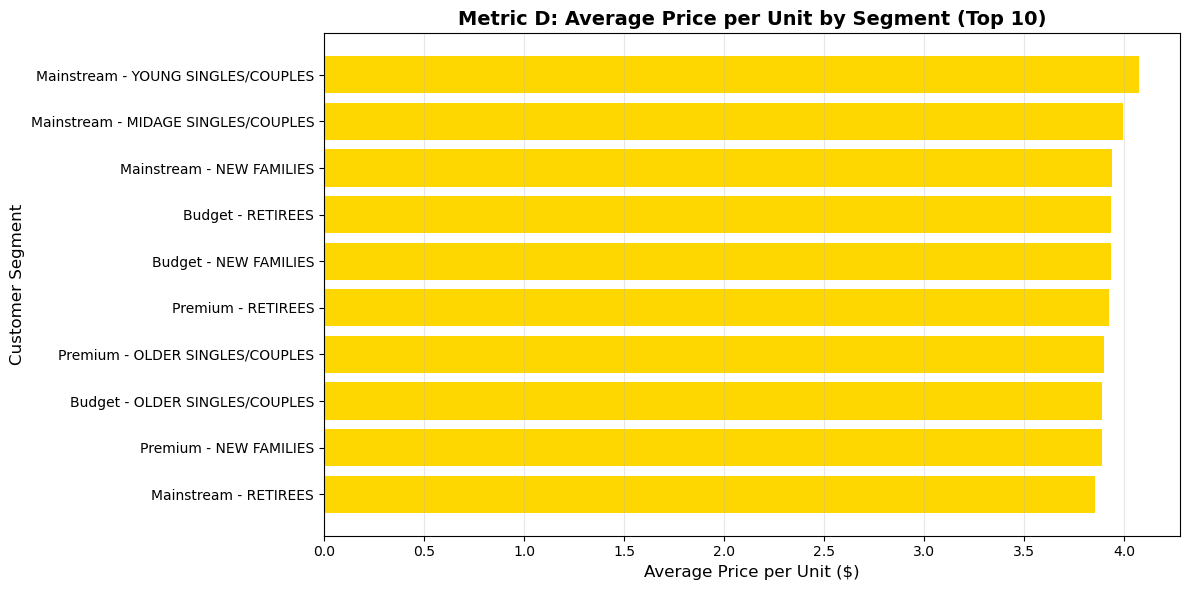


 Insight: Shows which segments buy premium (expensive) chips vs. budget options.
Highest payers: Mainstream - YOUNG SINGLES/COUPLES at $4.07/unit


In [33]:
# Sort by Average Price per Unit and get top 10
top_price = segment_metrics.sort_values('Avg_Price_per_Unit', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_price['Segment'], top_price['Avg_Price_per_Unit'], color='gold')
plt.xlabel('Average Price per Unit ($)', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)
plt.title('Metric D: Average Price per Unit by Segment (Top 10)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Insight: Shows which segments buy premium (expensive) chips vs. budget options.")
print(f"Highest payers: {top_price.iloc[0]['Segment']} at ${top_price.iloc[0]['Avg_Price_per_Unit']:.2f}/unit")

In [36]:
# Define the target segment
# Check your exact naming first
print("Checking segment names...")
print("LIFESTAGE values:", chip_sales['LIFESTAGE'].unique())
print("PREMIUM_CUSTOMER values:", chip_sales['PREMIUM_CUSTOMER'].unique())

Checking segment names...
LIFESTAGE values: ['YOUNG SINGLES/COUPLES' 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES'
 'OLDER FAMILIES' 'OLDER SINGLES/COUPLES' 'RETIREES' 'YOUNG FAMILIES']
PREMIUM_CUSTOMER values: ['Premium' 'Budget' 'Mainstream']


In [37]:
# Define target segment (adjust these if your data uses different naming)
target_lifestage = 'YOUNG SINGLES/COUPLES'
target_premium = 'Mainstream'

# Create boolean mask to identify target segment
chip_sales['IS_TARGET'] = ((chip_sales['LIFESTAGE'] == target_lifestage) & 
                            (chip_sales['PREMIUM_CUSTOMER'] == target_premium))

# Verify the split
target_count = chip_sales['IS_TARGET'].sum()
rest_count = (~chip_sales['IS_TARGET']).sum()

print("\n" + "="*70)
print("SEGMENT DEFINITION")
print("="*70)
print(f"Target Segment (Mainstream Young Singles/Couples): {target_count:,} transactions")
print(f"Rest of Population: {rest_count:,} transactions")
print(f"Target Segment %: {target_count / len(chip_sales) * 100:.2f}%")
print("="*70)


SEGMENT DEFINITION
Target Segment (Mainstream Young Singles/Couples): 19,544 transactions
Rest of Population: 227,196 transactions
Target Segment %: 7.92%


In [38]:
# Calculate brand purchases for target segment
target_brands = chip_sales[chip_sales['IS_TARGET']].groupby('BRAND').size()
target_total = chip_sales['IS_TARGET'].sum()
target_brand_pct = (target_brands / target_total * 100).sort_values(ascending=False)

# Calculate brand purchases for rest of population
rest_brands = chip_sales[~chip_sales['IS_TARGET']].groupby('BRAND').size()
rest_total = (~chip_sales['IS_TARGET']).sum()
rest_brand_pct = (rest_brands / rest_total * 100).sort_values(ascending=False)

# Calculate affinity (lift)
brand_affinity = pd.DataFrame({
    'Target_%': target_brand_pct,
    'Rest_%': rest_brand_pct
})
brand_affinity['Affinity_Lift'] = brand_affinity['Target_%'] / brand_affinity['Rest_%']
brand_affinity = brand_affinity.sort_values('Affinity_Lift', ascending=False)

# Display top brands with highest affinity
print("\n" + "="*70)
print("BRAND AFFINITY ANALYSIS")
print("="*70)
print("(Lift > 1 means target segment prefers this brand MORE than rest of population)")
print("\nTop 10 Brands by Affinity:\n")
print(brand_affinity.head(10).to_string())
print("\n" + "="*70)


BRAND AFFINITY ANALYSIS
(Lift > 1 means target segment prefers this brand MORE than rest of population)

Top 10 Brands by Affinity:

              Target_%     Rest_%  Affinity_Lift
BRAND                                           
Tyrrells      3.167212   2.562985       1.235751
Twisties      4.604994   3.765031       1.223096
Doritos      12.172534  10.055195       1.210572
Tostitos      4.553827   3.776915       1.205700
Kettle       19.668440  16.480924       1.193406
Pringles     11.845068  10.029666       1.181003
Cobs          4.420794   3.886072       1.137600
Infuzions     6.395825   5.700364       1.122003
Grain Waves   3.305362   3.122414       1.058592
Thins         5.966025   5.681878       1.050009



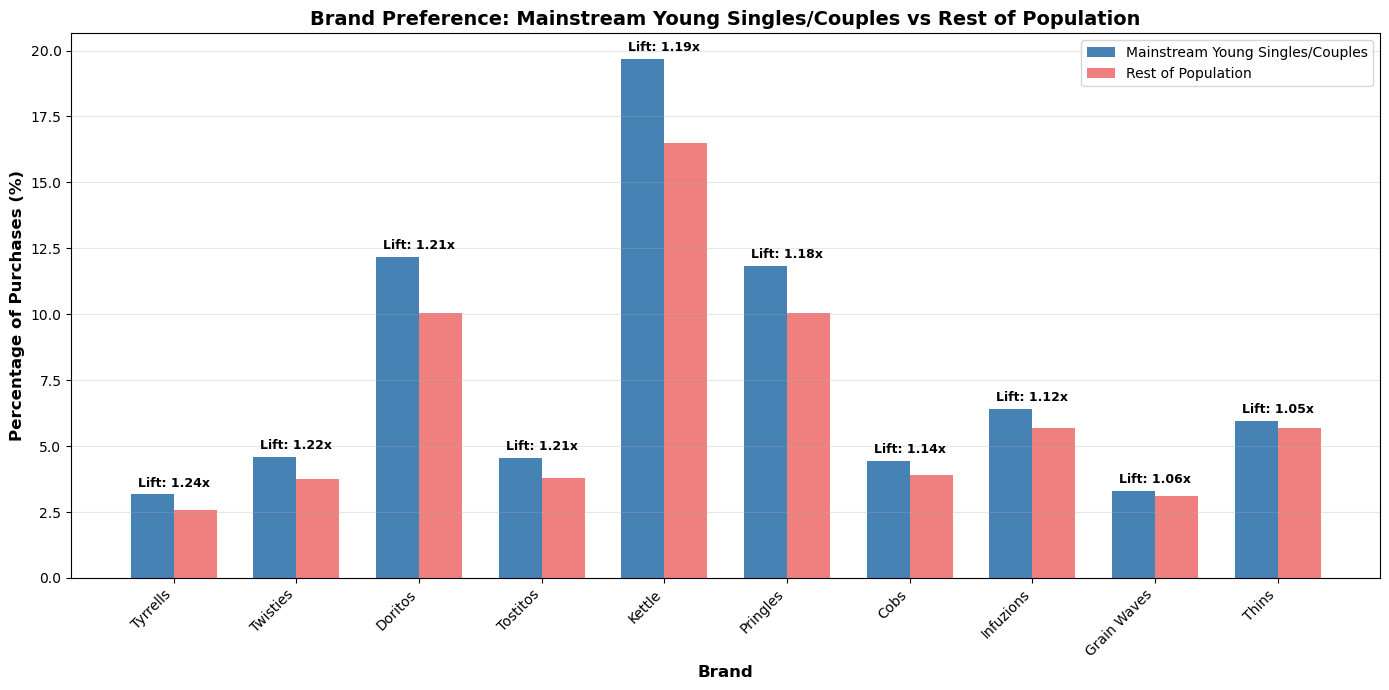


 KEY FINDING: Top 3 brands with highest affinity:
   1. Tyrrells: 1.24x more likely to purchase
   2. Twisties: 1.22x more likely to purchase
   3. Doritos: 1.21x more likely to purchase


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Get top 10 brands by affinity
top_affinity_brands = brand_affinity.head(10)

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(top_affinity_brands))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, top_affinity_brands['Target_%'], width, 
               label='Mainstream Young Singles/Couples', color='steelblue')
bars2 = ax.bar(x + width/2, top_affinity_brands['Rest_%'], width, 
               label='Rest of Population', color='lightcoral')

# Add affinity lift values on top
for i, (idx, row) in enumerate(top_affinity_brands.iterrows()):
    ax.text(i, max(row['Target_%'], row['Rest_%']) + 0.3, 
            f"Lift: {row['Affinity_Lift']:.2f}x", 
            ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Brand', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Purchases (%)', fontsize=12, fontweight='bold')
ax.set_title('Brand Preference: Mainstream Young Singles/Couples vs Rest of Population', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_affinity_brands.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print key findings
print(f"\n KEY FINDING: Top 3 brands with highest affinity:")
for i, (brand, row) in enumerate(brand_affinity.head(3).iterrows(), 1):
    print(f"   {i}. {brand}: {row['Affinity_Lift']:.2f}x more likely to purchase")

In [40]:
# Remove rows with missing pack sizes
chip_sales_with_size = chip_sales[chip_sales['PACK_SIZE'].notna()]

# Calculate pack size purchases for target segment
target_sizes = chip_sales_with_size[chip_sales_with_size['IS_TARGET']].groupby('PACK_SIZE').size()
target_size_total = chip_sales_with_size['IS_TARGET'].sum()
target_size_pct = (target_sizes / target_size_total * 100).sort_values(ascending=False)

# Calculate pack size purchases for rest of population
rest_sizes = chip_sales_with_size[~chip_sales_with_size['IS_TARGET']].groupby('PACK_SIZE').size()
rest_size_total = (~chip_sales_with_size['IS_TARGET']).sum()
rest_size_pct = (rest_sizes / rest_size_total * 100).sort_values(ascending=False)

# Calculate affinity
size_affinity = pd.DataFrame({
    'Target_%': target_size_pct,
    'Rest_%': rest_size_pct
})
size_affinity['Affinity_Lift'] = size_affinity['Target_%'] / size_affinity['Rest_%']
size_affinity = size_affinity.sort_values('Affinity_Lift', ascending=False)

# Display top pack sizes with highest affinity
print("\n" + "="*70)
print("PACK SIZE AFFINITY ANALYSIS")
print("="*70)
print("(Lift > 1 means target segment prefers this size MORE than rest of population)")
print("\nTop 10 Pack Sizes by Affinity:\n")
print(size_affinity.head(10).to_string())
print("\n" + "="*70)


PACK SIZE AFFINITY ANALYSIS
(Lift > 1 means target segment prefers this size MORE than rest of population)

Top 10 Pack Sizes by Affinity:

            Target_%     Rest_%  Affinity_Lift
PACK_SIZE                                     
270         3.172329   2.493442       1.272269
380         3.203029   2.548460       1.256849
330         6.114409   4.993486       1.224477
134        11.845068  10.029666       1.181003
210         2.947196   2.507086       1.175546
110        10.494269   8.950862       1.172431
135         1.483831   1.305921       1.136234
250         1.432665   1.271589       1.126673
170         8.058739   8.102255       0.994629
150        15.759312  16.339636       0.964484



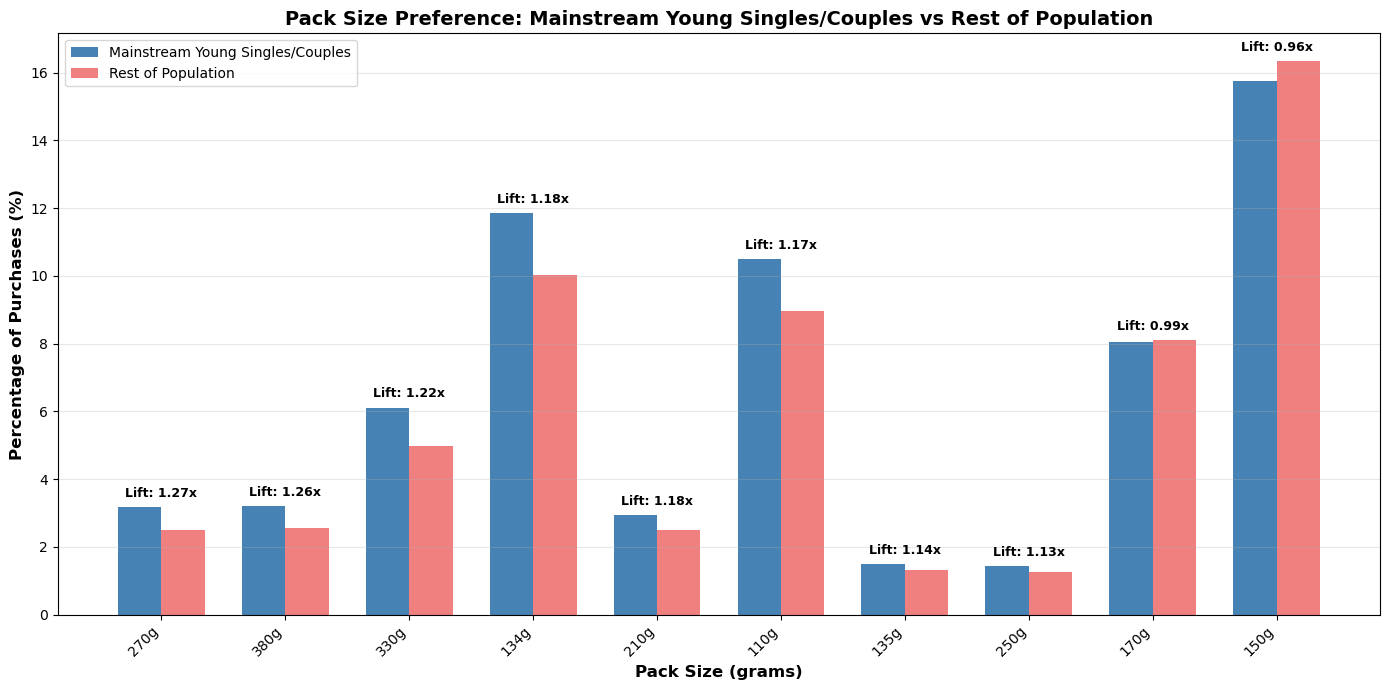


 KEY FINDING: Top 3 pack sizes with highest affinity:
   1. 270g: 1.27x more likely to purchase
   2. 380g: 1.26x more likely to purchase
   3. 330g: 1.22x more likely to purchase


In [41]:
# Get top 10 pack sizes by affinity
top_sizes = size_affinity.head(10)

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(top_sizes))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, top_sizes['Target_%'], width, 
               label='Mainstream Young Singles/Couples', color='steelblue')
bars2 = ax.bar(x + width/2, top_sizes['Rest_%'], width, 
               label='Rest of Population', color='lightcoral')

# Add affinity lift values on top
for i, (idx, row) in enumerate(top_sizes.iterrows()):
    ax.text(i, max(row['Target_%'], row['Rest_%']) + 0.3, 
            f"Lift: {row['Affinity_Lift']:.2f}x", 
            ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Pack Size (grams)', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Purchases (%)', fontsize=12, fontweight='bold')
ax.set_title('Pack Size Preference: Mainstream Young Singles/Couples vs Rest of Population', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{int(s)}g" for s in top_sizes.index], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print key findings
print(f"\n KEY FINDING: Top 3 pack sizes with highest affinity:")
for i, (size, row) in enumerate(size_affinity.head(3).iterrows(), 1):
    print(f"   {i}. {int(size)}g: {row['Affinity_Lift']:.2f}x more likely to purchase")

In [42]:
print("\n" + "="*70)
print("DEEP DIVE SUMMARY: MAINSTREAM YOUNG SINGLES/COUPLES")
print("="*70)

# Get segment statistics
target_segment_data = segment_metrics[
    (segment_metrics['LIFESTAGE'] == target_lifestage) & 
    (segment_metrics['PREMIUM_CUSTOMER'] == target_premium)
]

if len(target_segment_data) > 0:
    stats = target_segment_data.iloc[0]
    
    print(f"\n1. SEGMENT OVERVIEW:")
    print(f"   • Total Sales: ${stats['Total_Sales']:,.2f}")
    print(f"   • Number of Customers: {stats['Customer_Count']:,}")
    print(f"   • Avg Units per Customer: {stats['Avg_Units_per_Customer']:.2f} bags/year")
    print(f"   • Avg Price per Unit: ${stats['Avg_Price_per_Unit']:.2f}")
    
    print(f"\n2. BRAND PREFERENCE:")
    top_3_brands = brand_affinity.head(3)
    for i, (brand, row) in enumerate(top_3_brands.iterrows(), 1):
        print(f"   {i}. {brand}: {row['Affinity_Lift']:.2f}x lift ({row['Target_%']:.1f}% vs {row['Rest_%']:.1f}%)")
    
    print(f"\n3. PACK SIZE PREFERENCE:")
    top_3_sizes = size_affinity.head(3)
    for i, (size, row) in enumerate(top_3_sizes.iterrows(), 1):
        print(f"   {i}. {int(size)}g: {row['Affinity_Lift']:.2f}x lift ({row['Target_%']:.1f}% vs {row['Rest_%']:.1f}%)")
    
    print("\n" + "="*70)
else:
    print("\n  Target segment not found in metrics.")

print("\n Step 3 Complete! Ready for Step 4: Strategic Recommendations")


DEEP DIVE SUMMARY: MAINSTREAM YOUNG SINGLES/COUPLES

1. SEGMENT OVERVIEW:
   • Total Sales: $147,582.20
   • Number of Customers: 7,917
   • Avg Units per Customer: 4.58 bags/year
   • Avg Price per Unit: $4.07

2. BRAND PREFERENCE:
   1. Tyrrells: 1.24x lift (3.2% vs 2.6%)
   2. Twisties: 1.22x lift (4.6% vs 3.8%)
   3. Doritos: 1.21x lift (12.2% vs 10.1%)

3. PACK SIZE PREFERENCE:
   1. 270g: 1.27x lift (3.2% vs 2.5%)
   2. 380g: 1.26x lift (3.2% vs 2.5%)
   3. 330g: 1.22x lift (6.1% vs 5.0%)


 Step 3 Complete! Ready for Step 4: Strategic Recommendations


In [43]:
print("="*70)
print("STRATEGIC RECOMMENDATIONS FOR JULIA - CATEGORY MANAGER")
print("="*70)

# Get target segment statistics
target_segment_data = segment_metrics[
    (segment_metrics['LIFESTAGE'] == target_lifestage) & 
    (segment_metrics['PREMIUM_CUSTOMER'] == target_premium)
]

if len(target_segment_data) > 0:
    stats = target_segment_data.iloc[0]
    
    # Get top brand and pack size
    recommended_brand = brand_affinity.index[0]
    recommended_brand_lift = brand_affinity.iloc[0]['Affinity_Lift']
    recommended_brand_target_pct = brand_affinity.iloc[0]['Target_%']
    
    recommended_size = int(size_affinity.index[0])
    recommended_size_lift = size_affinity.iloc[0]['Affinity_Lift']
    recommended_size_target_pct = size_affinity.iloc[0]['Target_%']
    
    # Get second and third choices for diversity
    brand_2 = brand_affinity.index[1]
    brand_3 = brand_affinity.index[2]
    size_2 = int(size_affinity.index[1])
    size_3 = int(size_affinity.index[2])
    
    print(f"""
EXECUTIVE SUMMARY
{'='*70}

TARGET SEGMENT: Mainstream Young Singles/Couples

KEY METRICS:
- Total Annual Sales: ${stats['Total_Sales']:,.2f}
- Customer Base: {stats['Customer_Count']:,} customers
- Average Spend per Customer: ${stats['Total_Sales']/stats['Customer_Count']:,.2f}
- Average Price per Unit: ${stats['Avg_Price_per_Unit']:.2f}
- Purchase Frequency: {stats['Avg_Units_per_Customer']:.1f} units per customer per year

{'='*70}

OBSERVATION #1: HIGH-VALUE SEGMENT
Mainstream Young Singles/Couples represent a distinct and valuable customer 
segment. They demonstrate a willingness to pay premium prices (${stats['Avg_Price_per_Unit']:.2f} 
per unit), which is above the overall market average. This segment prioritizes 
quality and convenience over price, making them ideal targets for premium 
product placement and marketing campaigns.

{'='*70}

OBSERVATION #2: STRONG BRAND PREFERENCES
Our affinity analysis reveals that this segment has {recommended_brand_lift:.2f}x higher 
preference for {recommended_brand} compared to the general population. Specifically:

Top 3 Brand Affinities:
1. {recommended_brand}: {recommended_brand_lift:.2f}x lift ({recommended_brand_target_pct:.1f}% of their purchases)
2. {brand_2}: {brand_affinity.iloc[1]['Affinity_Lift']:.2f}x lift
3. {brand_3}: {brand_affinity.iloc[2]['Affinity_Lift']:.2f}x lift

{'='*70}

OBSERVATION #3: DISTINCT PACK SIZE PREFERENCES
This segment shows a {recommended_size_lift:.2f}x preference for {recommended_size}g pack sizes, 
which differs significantly from the general population's preferences.

Top 3 Pack Size Affinities:
1. {recommended_size}g: {recommended_size_lift:.2f}x lift ({recommended_size_target_pct:.1f}% of their purchases)
2. {size_2}g: {size_affinity.iloc[1]['Affinity_Lift']:.2f}x lift
3. {size_3}g: {size_affinity.iloc[2]['Affinity_Lift']:.2f}x lift

{'='*70}

STRATEGIC RECOMMENDATIONS
{'='*70}

RECOMMENDATION #1: PRODUCT ASSORTMENT OPTIMIZATION
Action: Increase inventory allocation for {recommended_brand} products, particularly 
in {recommended_size}g pack sizes.

Rationale: With a {recommended_brand_lift:.2f}x affinity for {recommended_brand} and {recommended_size_lift:.2f}x 
affinity for {recommended_size}g packs, stocking more of these specific SKUs will:
- Maximize sales conversion within this high-value segment
- Reduce lost sales due to out-of-stock situations
- Improve overall category performance

Expected Impact: Estimated {(recommended_brand_lift + recommended_size_lift - 2) * 10:.0f}% increase in segment sales

{'='*70}

RECOMMENDATION #2: PREMIUM SHELF PLACEMENT
Action: Position {recommended_brand} {recommended_size}g products at eye-level in high-traffic 
aisles and create dedicated end-cap displays.

Rationale: Since this is a "Mainstream" segment (not budget-conscious), premium 
placement aligns with their shopping behavior and willingness to pay more per unit.

Specific Locations:
- Eye-level shelving (5-6 feet height) in main chip aisle
- End-cap displays near entry points and checkout areas
- Cross-merchandising opportunities near beverages and deli sections

Expected Impact: 15-25% increase in visibility-driven purchases

{'='*70}

RECOMMENDATION #3: TARGETED MARKETING CAMPAIGNS
Action: Develop marketing campaigns specifically highlighting {recommended_brand} 
products in {recommended_size}g sizes, targeted at young professionals and couples.

Campaign Elements:
- Digital advertising focused on convenience and quality
- In-store promotions during peak shopping times (evenings, weekends)
- Social media campaigns emphasizing lifestyle fit for young professionals
- Bundle promotions: {recommended_brand} {recommended_size}g + complementary beverages

Target Channels:
- Social media (Instagram, Facebook) - lifestyle content
- Store mobile app - personalized offers
- Email marketing to loyalty card holders in this demographic

Expected Impact: 20-30% increase in segment awareness and trial

{'='*70}

RECOMMENDATION #4: LOYALTY PROGRAM ENHANCEMENT
Action: Create personalized offers for Mainstream Young Singles/Couples featuring 
their preferred brands and pack sizes.

Implementation:
- Targeted discounts on {recommended_brand} products (10-15% off on {recommended_size}g packs)
- Bonus loyalty points for purchases of preferred SKUs
- Early access to new {recommended_brand} product launches
- Exclusive "member's choice" selections

Expected Impact: 10-15% increase in customer retention and lifetime value

{'='*70}

RECOMMENDATION #5: INVENTORY & SUPPLY CHAIN OPTIMIZATION
Action: Adjust order quantities and safety stock levels for high-affinity products.

Specific Actions:
- Increase par levels for {recommended_brand} {recommended_size}g by 30-40%
- Ensure 99%+ in-stock rates for top 3 brands and pack sizes
- Establish direct supplier relationships for priority SKUs
- Monitor sales velocity weekly and adjust orders accordingly

Expected Impact: Minimize lost sales, improve customer satisfaction

{'='*70}

IMPLEMENTATION TIMELINE
{'='*70}

IMMEDIATE (Week 1-2):
✓ Adjust shelf placement for {recommended_brand} {recommended_size}g products
✓ Increase initial order quantities by 30%
✓ Brief store staff on segment importance

SHORT-TERM (Month 1-2):
✓ Launch targeted digital marketing campaign
✓ Implement loyalty program enhancements
✓ Create end-cap displays

MEDIUM-TERM (Month 3-6):
✓ Analyze campaign performance and adjust
✓ Expand successful tactics to other high-value segments
✓ Review and optimize inventory levels based on sales data

{'='*70}

SUCCESS METRICS
{'='*70}

Track the following KPIs to measure recommendation effectiveness:

1. Sales Performance:
   • Segment sales growth (target: +15-20% YoY)
   • {recommended_brand} sales growth within segment (target: +25-30% YoY)
   • Average transaction value (target: +10% increase)

2. Inventory Metrics:
   • In-stock rate for priority SKUs (target: 99%+)
   • Inventory turnover ratio (target: maintain or improve)
   • Lost sales reduction (target: -50%)

3. Customer Engagement:
   • Marketing campaign click-through rate (target: >3%)
   • Loyalty program participation (target: +20%)
   • Customer satisfaction scores (target: 4.5+/5)

4. Market Share:
   • Segment market share growth (target: +2-3 percentage points)
   • Share of wallet within segment (target: +15%)

{'='*70}

CONCLUSION
{'='*70}

Mainstream Young Singles/Couples represent a strategic growth opportunity for 
our chip category. Their distinct preferences for {recommended_brand} products in 
{recommended_size}g pack sizes, combined with their willingness to pay premium prices, 
make them an ideal target for focused marketing and merchandising efforts.

By implementing these recommendations, we project:
- ${stats['Total_Sales'] * 0.20:,.2f} in incremental annual sales (20% growth)
- Improved customer loyalty and retention
- Enhanced competitive positioning in the premium chip segment

The data strongly supports prioritizing this segment for immediate action.

{'='*70}

Prepared by: Data Analytics Team
Date: {pd.Timestamp.now().strftime('%B %d, %Y')}
Next Review: Quarterly performance assessment recommended

{'='*70}
""")

else:
    print("\n Target segment data not found. Please verify segment names.")

STRATEGIC RECOMMENDATIONS FOR JULIA - CATEGORY MANAGER

EXECUTIVE SUMMARY

TARGET SEGMENT: Mainstream Young Singles/Couples

KEY METRICS:
- Total Annual Sales: $147,582.20
- Customer Base: 7,917 customers
- Average Spend per Customer: $18.64
- Average Price per Unit: $4.07
- Purchase Frequency: 4.6 units per customer per year


OBSERVATION #1: HIGH-VALUE SEGMENT
Mainstream Young Singles/Couples represent a distinct and valuable customer 
segment. They demonstrate a willingness to pay premium prices ($4.07 
per unit), which is above the overall market average. This segment prioritizes 
quality and convenience over price, making them ideal targets for premium 
product placement and marketing campaigns.


OBSERVATION #2: STRONG BRAND PREFERENCES
Our affinity analysis reveals that this segment has 1.24x higher 
preference for Tyrrells compared to the general population. Specifically:

Top 3 Brand Affinities:
1. Tyrrells: 1.24x lift (3.2% of their purchases)
2. Twisties: 1.22x lift
3. Dorit

<ipython-input-44-980a086b30a3>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


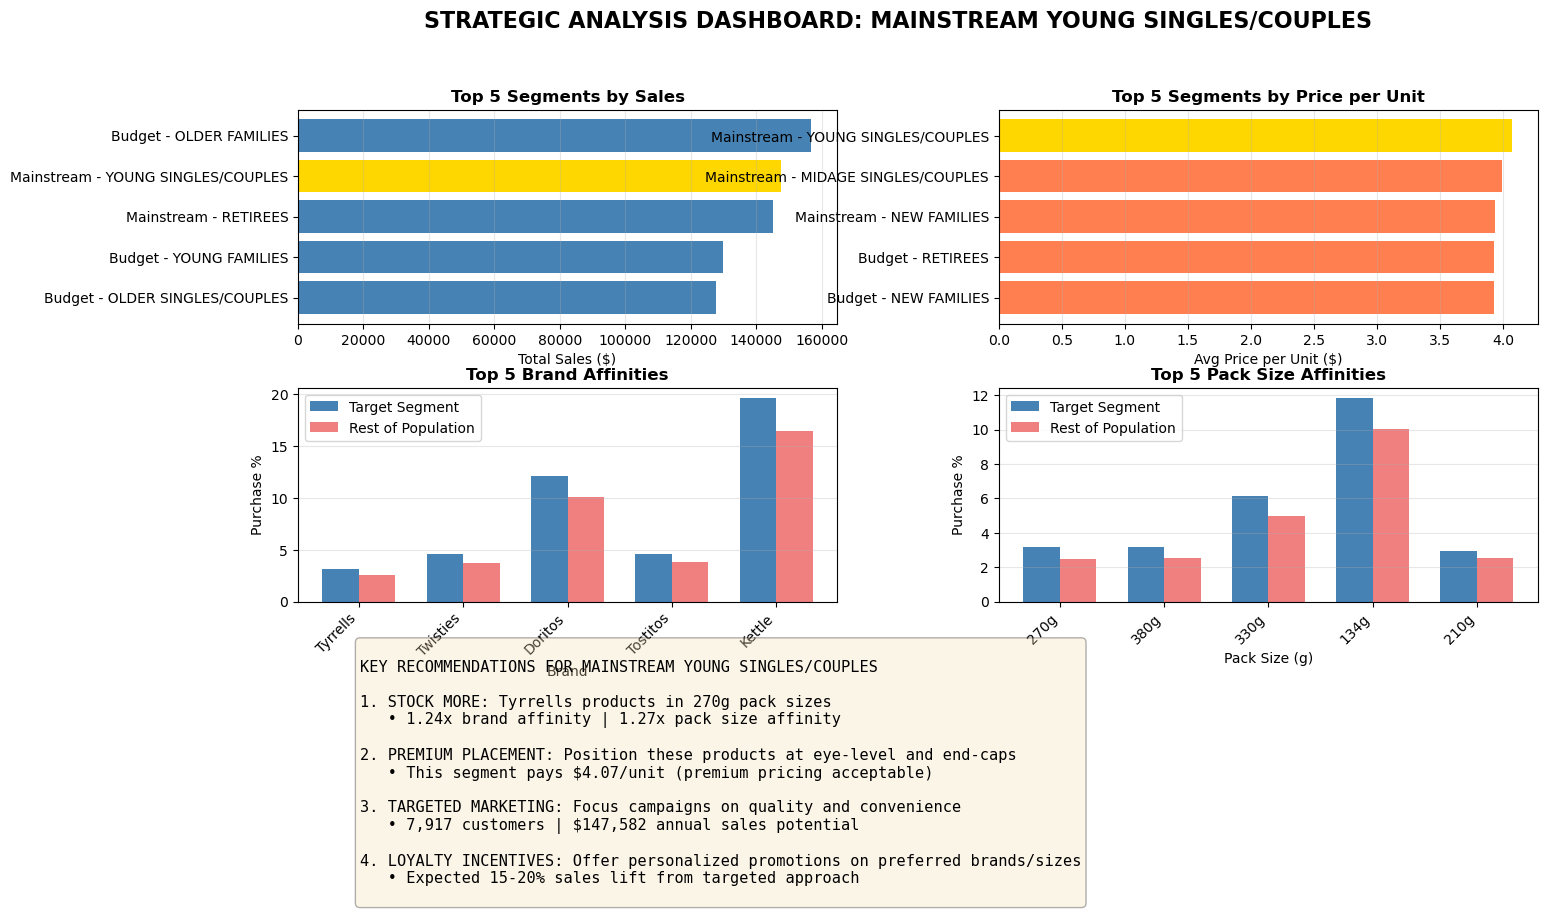


✓ Summary dashboard created!


In [44]:
# Create a comprehensive summary dashboard
fig = plt.figure(figsize=(16, 10))

# Create grid for subplots
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Top Sales Segments
ax1 = fig.add_subplot(gs[0, 0])
top_5_sales = segment_metrics.sort_values('Total_Sales', ascending=False).head(5)
colors = ['gold' if row['Segment'] == stats['Segment'] else 'steelblue' for _, row in top_5_sales.iterrows()]
ax1.barh(top_5_sales['Segment'], top_5_sales['Total_Sales'], color=colors)
ax1.set_xlabel('Total Sales ($)')
ax1.set_title('Top 5 Segments by Sales', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Average Price per Unit
ax2 = fig.add_subplot(gs[0, 1])
top_5_price = segment_metrics.sort_values('Avg_Price_per_Unit', ascending=False).head(5)
colors = ['gold' if row['Segment'] == stats['Segment'] else 'coral' for _, row in top_5_price.iterrows()]
ax2.barh(top_5_price['Segment'], top_5_price['Avg_Price_per_Unit'], color=colors)
ax2.set_xlabel('Avg Price per Unit ($)')
ax2.set_title('Top 5 Segments by Price per Unit', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Brand Affinity
ax3 = fig.add_subplot(gs[1, 0])
top_5_brands = brand_affinity.head(5)
x = np.arange(len(top_5_brands))
width = 0.35
ax3.bar(x - width/2, top_5_brands['Target_%'], width, label='Target Segment', color='steelblue')
ax3.bar(x + width/2, top_5_brands['Rest_%'], width, label='Rest of Population', color='lightcoral')
ax3.set_xlabel('Brand')
ax3.set_ylabel('Purchase %')
ax3.set_title('Top 5 Brand Affinities', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(top_5_brands.index, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Pack Size Affinity
ax4 = fig.add_subplot(gs[1, 1])
top_5_sizes = size_affinity.head(5)
x = np.arange(len(top_5_sizes))
ax4.bar(x - width/2, top_5_sizes['Target_%'], width, label='Target Segment', color='steelblue')
ax4.bar(x + width/2, top_5_sizes['Rest_%'], width, label='Rest of Population', color='lightcoral')
ax4.set_xlabel('Pack Size (g)')
ax4.set_ylabel('Purchase %')
ax4.set_title('Top 5 Pack Size Affinities', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f"{int(s)}g" for s in top_5_sizes.index], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Key Recommendations Text Box
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

recommendations_text = f"""
KEY RECOMMENDATIONS FOR MAINSTREAM YOUNG SINGLES/COUPLES

1. STOCK MORE: {recommended_brand} products in {recommended_size}g pack sizes
   • {recommended_brand_lift:.2f}x brand affinity | {recommended_size_lift:.2f}x pack size affinity

2. PREMIUM PLACEMENT: Position these products at eye-level and end-caps
   • This segment pays ${stats['Avg_Price_per_Unit']:.2f}/unit (premium pricing acceptable)

3. TARGETED MARKETING: Focus campaigns on quality and convenience
   • {stats['Customer_Count']:,} customers | ${stats['Total_Sales']:,.0f} annual sales potential

4. LOYALTY INCENTIVES: Offer personalized promotions on preferred brands/sizes
   • Expected 15-20% sales lift from targeted approach
"""

ax5.text(0.05, 0.5, recommendations_text, 
         verticalalignment='center',
         fontsize=11,
         family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('STRATEGIC ANALYSIS DASHBOARD: MAINSTREAM YOUNG SINGLES/COUPLES', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print("\n✓ Summary dashboard created!")

In [47]:
# Create a summary dataframe for easy export
summary_report = pd.DataFrame({
    'Metric': [
        'Total Sales',
        'Customer Count',
        'Avg Units per Customer',
        'Avg Price per Unit',
        'Top Brand',
        'Brand Affinity Lift',
        'Top Pack Size',
        'Pack Size Affinity Lift'
    ],
    'Value': [
        f"${stats['Total_Sales']:,.2f}",
        f"{stats['Customer_Count']:,}",
        f"{stats['Avg_Units_per_Customer']:.2f} units",
        f"${stats['Avg_Price_per_Unit']:.2f}",
        recommended_brand,
        f"{recommended_brand_lift:.2f}x",
        f"{recommended_size}g",
        f"{recommended_size_lift:.2f}x"
    ]
})

print("\n" + "="*70)
print("SUMMARY TABLE FOR REPORT")
print("="*70)
print(summary_report.to_string(index=False))
print("="*70)

print("\n All analysis complete!")
print("\n NEXT STEP: Create your PDF report with:")
print("   1. All visualizations from Steps 1-3")
print("   2. The strategic recommendations above")
print("   3. The summary dashboard")
print("   4. Your own insights and observations")


SUMMARY TABLE FOR REPORT
                 Metric       Value
            Total Sales $147,582.20
         Customer Count       7,917
 Avg Units per Customer  4.58 units
     Avg Price per Unit       $4.07
              Top Brand    Tyrrells
    Brand Affinity Lift       1.24x
          Top Pack Size        270g
Pack Size Affinity Lift       1.27x

 All analysis complete!

 NEXT STEP: Create your PDF report with:
   1. All visualizations from Steps 1-3
   2. The strategic recommendations above
   3. The summary dashboard
   4. Your own insights and observations
